In [ ]:
#20241121
#This is for data mining course
#Source paper: An Exemplars-Based Approach for Explainable Clustering: Complexity and Efficient Approximation Algorithms 
#URL: www.cs.ucdavis.edu/~davidson/SCCE-DMKD-main.zip

In [1442]:
from ExemplarClustering import ExemplarCluster as EC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from copy import deepcopy
from random import choices, seed
import numpy as np
import pickle, os

In [ ]:
seed(0)
print ('----------')
#embeddings_path = os.path.join('./ImageExperiments/embeddings1.pickle')
embeddings_path = os.path.join(r'C:\Users\henry\Desktop\研究所\paper\DM_paper\SCCE-DMKD-main\cifar10_embeddings.pickle')
data = pickle.loads(open(embeddings_path, "rb").read())
embeddings = data['embeddings']
labels = data['names']
print("Type:",type(data))
sampling_size = 20
testing_size = 40 - sampling_size
classes = 3
k = classes
pcs = 16
epsilon = 4.5
algorithm= 'kMeans'
#algorithm= 'Gonzalez'

embeddings = np.asarray(embeddings)
labels = np.asarray(labels)

sorted_indices = np.argsort(labels)
embeddings = embeddings[sorted_indices]
labels = labels[sorted_indices]

----------
Type: <class 'dict'>


In [ ]:
max_classes = 3
processed_classes = 0

new_embeddings = []
new_labels = []
test_embeddings = []
test_labels = []

current_label = None
indices = []

#從CIRFAR-10裡面挑三類
for i, label in enumerate(labels):
    if label != current_label: 
        if current_label is not None:
            if len(indices) < sampling_size + testing_size:
                raise ValueError(f"類別 {current_label} 數據不足！")
            new_embeddings.extend(embeddings[indices[:sampling_size]])
            new_labels.extend(labels[indices[:sampling_size]])
            test_embeddings.extend(embeddings[indices[sampling_size:sampling_size + testing_size]])
            test_labels.extend(labels[indices[sampling_size:sampling_size + testing_size]])
            processed_classes += 1
            if processed_classes >= max_classes:
                break

        current_label = label
        indices = []

    indices.append(i)

new_embeddings = np.array(new_embeddings)
test_embeddings = np.array(test_embeddings)
new_labels = np.array(new_labels)
test_labels = np.array(test_labels)


print("New embeddings shape:", new_embeddings.shape)
print("Test embeddings shape:", test_embeddings.shape)
print("New labels shape:", new_labels.shape)
print("Test labels shape:", test_labels.shape)

print('\n\nnew labels',new_labels)
print(len(new_labels))

New embeddings shape: (60, 20)
Test embeddings shape: (60, 20)
New labels shape: (60,)
Test labels shape: (60,)


new labels ['airplane' 'airplane' 'airplane' 'airplane' 'airplane' 'airplane'
 'airplane' 'airplane' 'airplane' 'airplane' 'airplane' 'airplane'
 'airplane' 'airplane' 'airplane' 'airplane' 'airplane' 'airplane'
 'airplane' 'airplane' 'automobile' 'automobile' 'automobile' 'automobile'
 'automobile' 'automobile' 'automobile' 'automobile' 'automobile'
 'automobile' 'automobile' 'automobile' 'automobile' 'automobile'
 'automobile' 'automobile' 'automobile' 'automobile' 'automobile'
 'automobile' 'bird' 'bird' 'bird' 'bird' 'bird' 'bird' 'bird' 'bird'
 'bird' 'bird' 'bird' 'bird' 'bird' 'bird' 'bird' 'bird' 'bird' 'bird'
 'bird' 'bird']
60


In [1445]:
embeddings = np.asarray(new_embeddings)
labels = new_labels

In [1446]:
pca = PCA(n_components=pcs)
pc = deepcopy(pca.fit_transform(embeddings))
pc_test = pca.fit_transform(test_embeddings)

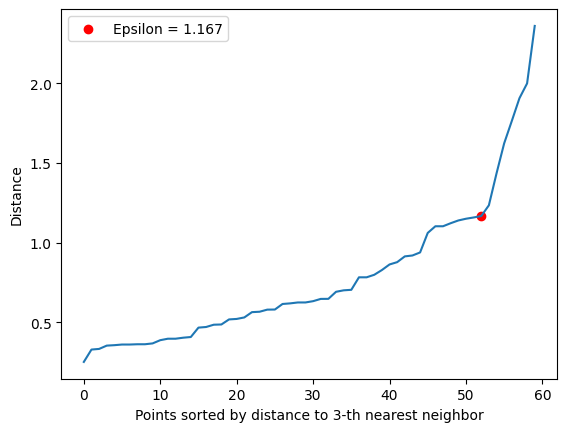

最佳的 epsilon 值為: 1.167


In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

kk = 4 
nbrs = NearestNeighbors(n_neighbors=kk).fit(pc)
distances, indices = nbrs.kneighbors(pc)
distances = distances[:, -1]  
#取第k個最近鄰的距離

#排序距離
sorted_distances = np.sort(distances)

#找肘點
def find_elbow_point(sorted_distances):
    n_points = len(sorted_distances)
    all_indices = np.arange(n_points)
    
    #兩端點
    first_point = np.array([0, sorted_distances[0]])
    last_point = np.array([n_points - 1, sorted_distances[-1]])
    
    #點到直線der距離
    line_vector = last_point - first_point
    line_vector_norm = line_vector / np.linalg.norm(line_vector)
    distances_to_line = np.abs(np.cross(line_vector, np.vstack((all_indices, sorted_distances)).T - first_point)) / np.linalg.norm(line_vector)
    
    #最大距離點=肘部
    elbow_index = np.argmax(distances_to_line)
    return elbow_index, sorted_distances[elbow_index]

#answer
elbow_index, epsilon = find_elbow_point(sorted_distances)

plt.plot(sorted_distances)
plt.scatter(elbow_index, epsilon, color='red', label=f"Epsilon = {epsilon:.3f}")
plt.xlabel('Points sorted by distance to {}-th nearest neighbor'.format(k))
plt.ylabel('Distance')
plt.legend()
plt.show()

print(f"最佳的 epsilon 值為: {epsilon:.3f}")
#epsilon=4.5

In [1449]:
clustering = EC(pc, epsilon, k, algorithm=algorithm, verbose=False)
clustering.fit(bounded = True)
#print(clustering.find_exemplar_neighborhood())
clusters = clustering.get_clusters()
exemplars = clustering.get_exemplars()

bounded version


In [1450]:
O_exemplar_points = []
O_exemplar_labels = []
i = 1
for c in exemplars:
	for e in c:
		O_exemplar_points.append(pc[e])
		O_exemplar_labels.append(labels[(i-1)*sampling_size])
	i += 1

In [1451]:
i = 1
j = 0
cluster_centers = []
cluster_labels = []
for c in clusters:
	cluster_centers.append([])
	for p in c:
		cluster_centers[j].append(pc[p])
	cluster_centers[j] = np.asarray(np.mean(cluster_centers[j], axis=0))
	cluster_labels.append(labels[(i-1)*sampling_size])
	i += 1
	j += 1

In [1452]:
random_exemplars = []
random_labels = []

i = 0
for c in clusters:
	random_exemplars += choices(c, k=len(exemplars[i]))
	for j in range(len(exemplars[i])):
		random_labels.append(labels[i*sampling_size])
	i += 1
for j in range(len(random_exemplars)):
	random_exemplars[j] = pc[random_exemplars[j]]

In [1453]:
big_c = []
big_labels = []
i = 0
for c in clusters:
	for p in c:
		big_c.append(pc[p])
		big_labels.append(labels[i*sampling_size])
	i += 1

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances

def select_diverse_exemplars(cluster_points, num_exemplars):

    #計算點之間的歐幾里得距離
    distances = euclidean_distances(cluster_points, cluster_points)
    n_points = len(cluster_points)
    
    #選擇距離聚類中心最近的點作為第一個範例
    cluster_center = np.mean(cluster_points, axis=0)
    first_exemplar = np.argmin(np.linalg.norm(cluster_points - cluster_center, axis=1))
    selected = [first_exemplar]
    
    #迭代選擇範例點
    for _ in range(num_exemplars - 1):
        remaining = [i for i in range(n_points) if i not in selected]
        next_point = max(remaining, key=lambda x: min(distances[x, selected]))
        selected.append(next_point)
    
    return selected

D_exemplar_points = []
D_exemplar_labels = []

for i, c in enumerate(clusters):
    cluster_points = pc[c] 
    exemplars_indices = select_diverse_exemplars(cluster_points, len(exemplars[i]))
    
    for e in exemplars_indices:
        D_exemplar_points.append(cluster_points[e])
        D_exemplar_labels.append(labels[i * sampling_size])

In [1455]:
knnD = KNeighborsClassifier(n_neighbors=3)
knnD.fit(D_exemplar_points, D_exemplar_labels)

knnE = KNeighborsClassifier(n_neighbors=3)
knnE.fit(O_exemplar_points, O_exemplar_labels)
knnC = KNeighborsClassifier(n_neighbors=3)
knnC.fit(cluster_centers, cluster_labels)
knnR = KNeighborsClassifier(n_neighbors=3)
knnR.fit(random_exemplars, random_labels)
knnB = KNeighborsClassifier(n_neighbors=3)
knnB.fit(big_c, big_labels)

'''knnE = KNeighborsClassifier(n_neighbors=3)
knnE.fit(O_exemplar_points, O_exemplar_labels)
print ('Exemplar: ' + str(round(knnE.score(pc_test, test_labels),3)))'''

"knnE = KNeighborsClassifier(n_neighbors=3)\nknnE.fit(O_exemplar_points, O_exemplar_labels)\nprint ('Exemplar: ' + str(round(knnE.score(pc_test, test_labels),3)))"

In [1456]:
print ('Select_Diverse_Exemplar: ' + str(round(knnD.score(pc_test, test_labels),3)))
print ('Exemplar: ' + str(round(knnE.score(pc_test, test_labels),3)))
print ('Centorid: ' + str(round(knnC.score(pc_test, test_labels),3)))
print ('Random: ' + str(round(knnR.score(pc_test, test_labels),3)))
print ('Whole Cluster: ' + str(round(knnB.score(pc_test, test_labels),3)))

Select_Diverse_Exemplar: 0.333
Exemplar: 0.3
Centorid: 0.333
Random: 0.317
Whole Cluster: 0.333


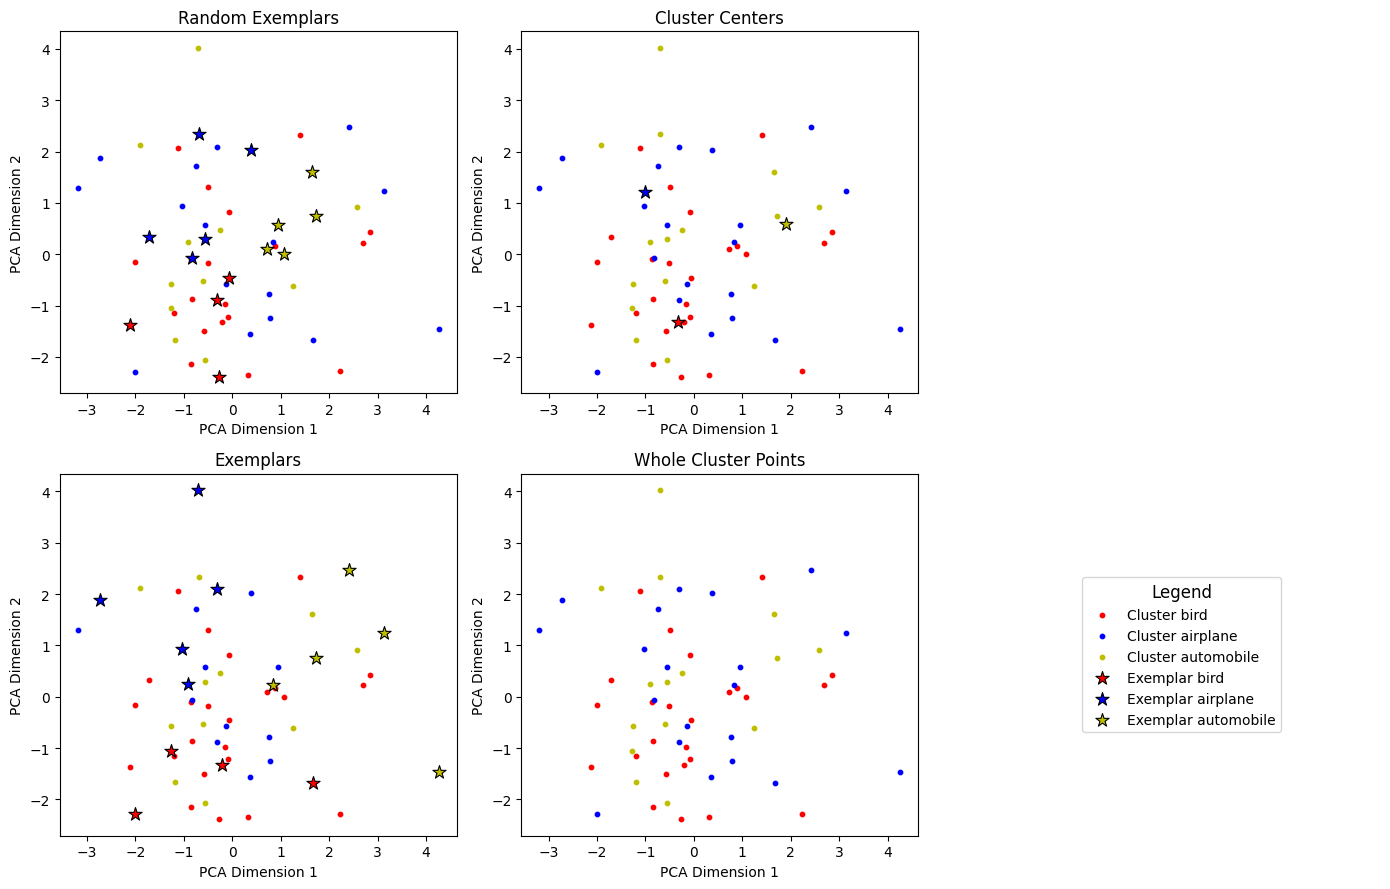

In [ ]:
import matplotlib.pyplot as plt

def plot_clusters(pos,points, labels, title, exemplars=None, exemplar_labels=None):
    plt.subplot(pos)
    points = np.array(points)
    
    unique_labels = list(set(labels))
    #colors = plt.cm.get_cmap("tab10", len(unique_labels))
    colors = ['r','b','y']
    #plt.figure(figsize=(5, 4))

    for i, label in enumerate(unique_labels):
        cluster_points = points[np.array(labels) == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, label=f'Cluster {label}', color=colors[i])

    if exemplars is not None:
        exemplars = np.array(exemplars)
        for i, label in enumerate(unique_labels):
            exemplar_points = exemplars[np.array(exemplar_labels) == label]
            plt.scatter(exemplar_points[:, 0], exemplar_points[:, 1], s=100, label=f'Exemplar {label}', color=colors[i], marker='*', edgecolors='k', linewidths=0.8)
    
    plt.title(title)
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")
    #plt.legend(loc="best", fontsize=8)  # 自動選擇最佳位置，並縮小字體
    #plt.savefig(f'{title}.png')
    #plt.show()

plt.figure(0,figsize=(14,9))

plot_clusters(
    pos=235,
    points=pc, 
    labels=big_labels, 
    title="Whole Cluster Points"
)

plot_clusters(
    pos=231,
    points=pc, 
    labels=big_labels, 
    title="Random Exemplars", 
    exemplars=random_exemplars, 
    exemplar_labels=random_labels
)

'''plot_clusters(
    pos=235,
    points=pc, 
    labels=big_labels, 
    title="Diverse Exemplars", 
    exemplars=D_exemplar_points, 
    exemplar_labels=D_exemplar_labels
)'''

plot_clusters(
    pos=232,
    points=pc, 
    labels=big_labels, 
    title="Cluster Centers", 
    exemplars=cluster_centers, 
    exemplar_labels=cluster_labels
)

plot_clusters(
    pos=234,
    points=pc, 
    labels=big_labels, 
    title="Exemplars", 
    exemplars=O_exemplar_points, 
    exemplar_labels=O_exemplar_labels
)

#plt.subplot(236)
#plt.legend()
#plt.axis('off')
ax6 = plt.subplot(236)
ax6.axis("off")
handles, plt_labels = ax6.get_figure().axes[1].get_legend_handles_labels()

plt.legend(
    handles, 
    plt_labels, 
    loc="center", 
    fontsize=10, 
    title="Legend", 
    title_fontsize=12,
    frameon=True
)

#plt.legend()
plt.tight_layout()
plt.savefig('./cmp_cifar_40.png')
plt.show()

>> 60


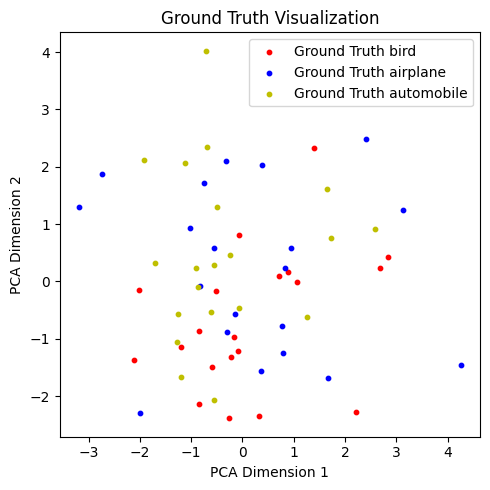

In [ ]:
def plot_ground_truth(points, true_labels, title):
    points = np.array(points)
    
    unique_labels = list(set(true_labels))
    colors = ['r','b','y'] 

    for i, label in enumerate(unique_labels):
        cluster_points = points[np.array(true_labels) == label]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=10, label=f'Ground Truth {label}', color=colors[i % len(colors)])
    
    plt.title(title)
    plt.xlabel("PCA Dimension 1")
    plt.ylabel("PCA Dimension 2")

plt.figure(1,figsize=(5,5))
#true_labels = labels[:len(pc)]  
print('>>',len(labels))

plot_ground_truth(
    points=pc,
    true_labels=labels,  
    title="Ground Truth Visualization"
)


plt.tight_layout()
plt.legend()
plt.savefig('./Ground Truth_40.png')
plt.show()